There are 2 parts in this Notebook.

1.   [Finding the best samples](#Section1)
2.   [Training on those samples](#Section2)
3.   [Training on random samples](#Section3)



<a name="Section1"></a>
# Finding most valuable $n(=500)$ data samples from $50,000$ samples.

## Imports

In [2]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from functools import partial
from collections.abc import Iterable

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

!pip install functorch
from functorch import make_functional_with_buffers, vmap, grad
from functorch.experimental import replace_all_batch_norm_modules_

import jax
import jax.numpy as jnp
# from jax import grad, jit, vmap
# from jax import random
# from jax.scipy.special import logsumexp
# from jax.example_libraries import stax, optimizers
# from jax.example_libraries.stax import BatchNorm, Conv, Dense, Flatten, Relu, AvgPool, LogSoftmax

ERROR: Could not find a version that satisfies the requirement functorch (from versions: none)
ERROR: No matching distribution found for functorch


ModuleNotFoundError: No module named 'functorch'

In [3]:
Device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(Device)

cuda:0


## Dataset

In [4]:
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """

    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })
# https://discuss.pytorch.org/t/how-to-retrieve-the-sample-indices-of-a-mini-batch/7948/19

In [5]:
transform = Compose([ToTensor(), Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))])
# train_data = CIFAR10("./", transform=transform, download=True)
CIFAR10WithIndices = dataset_with_indices(CIFAR10)
train_data = CIFAR10WithIndices("./", transform=transform, download=True)
train_data

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
           )

In [6]:
# train_images, train_labels, train_indices = next(iter(DataLoader(train_data, len(train_data), shuffle=True)))
# train_images.shape, train_labels.shape

In [7]:
# def one_hot(x, k, dtype=jnp.float32):
#   """Create a one-hot encoding of x of size k."""
#   return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [8]:
num_classes = 10
# train_images = jnp.array(train_images).reshape(50000, 32, 32, 3) # NWHC
# train_labels = one_hot(jnp.array(train_labels), num_classes)
# print("Train Images Shape", train_images.shape)
# print("Train Labels Shape", train_labels.shape)

In [9]:
# def iterate_minibatches(inputs, targets, batchsize):
#     assert inputs.shape[0] == targets.shape[0]
#     assert train_images.shape[0] % batchsize == 0
#     for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
#         excerpt = slice(start_idx, start_idx + batchsize)
#         yield inputs[excerpt], targets[excerpt]

## Model

In [10]:
def get_model():
    return nn.Sequential(
    nn.Conv2d(3,16,3,1,1), nn.BatchNorm2d(16), nn.ReLU(),
    nn.Conv2d(16,32,3,2,2), nn.BatchNorm2d(32), nn.ReLU(),
    nn.Conv2d(32,64,3,2,2), nn.BatchNorm2d(64), nn.ReLU(),
    nn.Conv2d(64,128,3,2,2), nn.BatchNorm2d(128), nn.ReLU(),
    nn.AvgPool2d(4), nn.Flatten(),
    nn.Linear(128, num_classes), nn.LogSoftmax(dim=-1)
    )
# init_fun, conv_net = stax.serial(Conv(16, (3, 3), (1, 1), padding=[(1,1), (1,1)]),
#                                  BatchNorm(), Relu,
#                                  Conv(32, (3, 3), (2, 2), padding=[(1,1), (1,1)]),
#                                  BatchNorm(), Relu,
#                                  Conv(64, (3, 3), (2, 2), padding=[(1,1), (1,1)]),
#                                  BatchNorm(), Relu,
#                                  Conv(128, (3, 3), (2, 2), padding=[(1,1), (1,1)]), 
#                                  BatchNorm(), Relu,
#                                  AvgPool((4,4)),
#                                  Flatten,
#                                  Dense(num_classes),
#                                  LogSoftmax)

In [11]:
model = get_model().to(Device)
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        nn.init.normal_(m.bias)
model.apply(init_weights)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=128, out_features=10, bias=True)
  (15): LogSoftmax(dim=-1)
)

In [12]:
conv_net, params, buffers = make_functional_with_buffers(model)
replace_all_batch_norm_modules_(conv_net)
# init_wrapper = partial(init_fun, input_shape=(10, 32, 32, 3))
# _, params = init_wrapper(random.PRNGKey(0))

FunctionalModuleWithBuffers(
  (stateless_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): ReLU()
    (12): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=128, out_features=10, bias=True)
    (15): LogSoftmax(dim=-1)
  )
)

In [13]:
def init_network_params(seed=0):
    torch.manual_seed(seed)
    model = get_model().to(Device)
    model.apply(init_weights)
    conv_net, params, buffers = make_functional_with_buffers(model)
    replace_all_batch_norm_modules_(conv_net)
    return conv_net, params, buffers
conv_net, params, buffers = init_network_params()

In [14]:
from operator import itemgetter
p_inds = [0,1,4,5,8, 9, 12,13, 16, 17]

In [15]:
select_inds = itemgetter(*p_inds)
sparams = select_inds(params)
len(sparams)

10

In [16]:
for x in sparams:
    if hasattr(x, 'shape'):
        print(f"Param: {x.shape}")
    elif isinstance(x, Iterable):
        for y in x:
            print(f"Param: {y.shape}", end=" ")
        print()
    else:
        print(f"Param: {len(x)}")

Param: torch.Size([16, 3, 3, 3])
Param: torch.Size([16])
Param: torch.Size([32, 16, 3, 3])
Param: torch.Size([32])
Param: torch.Size([64, 32, 3, 3])
Param: torch.Size([64])
Param: torch.Size([128, 64, 3, 3])
Param: torch.Size([128])
Param: torch.Size([10, 128])
Param: torch.Size([10])


In [17]:
@grad
def loss_gradient(params, x, y):
    x = x.unsqueeze(0)
    y = y.unsqueeze(0)
    preds = conv_net(params, buffers, x)
    return F.nll_loss(preds, y)

In [18]:
batched_loss = vmap(loss_gradient, (None, 0,0), )

In [19]:
BatchSize = 500
loader = DataLoader(train_data, BatchSize, shuffle=True, num_workers=2, pin_memory=True)
# loader = iterate_minibatches(train_images, train_labels, batchsize=BatchSize)

## Too much memory Consumption

In [20]:
# gradients = [[None, None] for i in range(len(params))]
# for i, batch in enumerate(loader):
#     images, labels = batch
#     gradient = batched_loss(params, images, labels)
#     if gradients[0][0] is not None:
#         for j in range(len(params)):
#             gradients[j][0] = np.concatenate([gradients[j][0], np.asarray(gradient[j][0])])
#             gradients[j][1] = np.concatenate([gradients[j][1], np.asarray(gradient[j][1])])
#     else:
#         for j in range(len(params)):
#             gradients[j][0] = np.asarray(gradient[j][0])
#             gradients[j][1] = np.asarray(gradient[j][1])
#     break

In [21]:
# net_gradients = [[None, None] for i in range(len(params))]
# for j in range(len(params)):
#     net_gradients[j][0] = jnp.mean(gradients[j][0], axis=0)
#     net_gradients[j][1] = jnp.mean(gradients[j][1], axis=0)

## Finding Net Gradient first

In [22]:
def get_net_gradeints(params, dataset, batch_size):
    net_gradients = [None for i in range(len(params))]
    loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    progress_bar = tqdm(enumerate(loader), total = len(dataset)//batch_size, desc="Net Gradients", leave=False)
    for i, batch in progress_bar:
        images, labels, _ = batch
        torch.cuda.empty_cache()
        images, labels = images.to(Device), labels.to(Device)
        gradient = batched_loss(params, images, labels)
        if net_gradients[0] is not None:
            for j in range(len(params)):
                net_gradients[j] += gradient[j].sum(axis=0).cpu().detach().numpy()
        else:
            for j in range(len(params)):
                net_gradients[j] = gradient[j].sum(axis=0).cpu().detach().numpy()

    for j in range(len(params)):
        net_gradients[j] /= len(dataset)
    return net_gradients
# net_gradients = get_net_gradeints(params, train_data, batch_size=BatchSize)

Net Gradients:   0%|          | 0/100 [00:00<?, ?it/s]

Finding Cosine Similarity between gradients per sample with gradient over entire dataset

In [24]:
def cosinesimilarity(a,b):
    return np.divide(np.dot(a, b.T).squeeze(),  (np.linalg.norm(a, axis=-1) * np.linalg.norm(b)))
# def cosinesimilarity(a,b):
#     return jnp.divide(jnp.dot(a, b.T),  (jnp.linalg.norm(a) * jnp.linalg.norm(b)))

In [25]:
# cs = vmap(cosinesimilarity, (0, None))

In [26]:
def get_similarities(params, dataset, batch_size, net_gradients):
    loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    similarities = []
    img_indices = []
    progress_bar = tqdm(enumerate(loader), total = len(dataset)//batch_size, desc="Per Sample Gradient Similarity", leave=False)
    for i, batch in progress_bar:
        imgs, label, inds = batch
        torch.cuda.empty_cache()
        imgs, label, inds = imgs.to(Device), label.to(Device), inds.numpy()
        gradient = batched_loss(params, imgs, label)
        sim=0
        for j in range(len(params)):
            sim += cosinesimilarity(gradient[j].reshape(batch_size,-1).cpu().detach().numpy(), net_gradients[j].reshape(1,-1))
        similarities.append(sim)
        img_indices.append(inds)
    return np.concatenate(similarities), np.concatenate(img_indices)
# similarities, img_indices = get_similarities(params, train_data, BatchSize, net_gradients)


In [27]:
# similarities.shape, img_indices.shape

## Finding top n similar samples for k iterations

In [ ]:
iterations = 100
topn = 100
BatchSize = 2000
good_inds = []
for k in tqdm(range(iterations), desc="Iterations"):
    conv_net, params, buffers = init_network_params(k)
    net_gradients = get_net_gradeints(params, train_data, BatchSize)
    similarities, img_indices = get_similarities(params, train_data, BatchSize, net_gradients)
    
    inds = np.argpartition(-np.asarray(similarities).squeeze(), topn)[:topn]
    good_inds.append(img_indices[inds])

good_inds = np.concatenate(good_inds)

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/25 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/25 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/25 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/25 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/25 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
inds.shape

In [ ]:
img_indices[inds].shape

In [ ]:
values, counts = np.unique(good_inds, return_counts=True)
# ref:https://stackoverflow.com/a/28736715/13730689

In [ ]:
inds = np.argpartition(-counts, kth=topn)[:topn]

In [ ]:
train_labels = torch.tensor(train_data.targets)

In [ ]:
np.unique(train_labels[inds], return_counts=True)

In [ ]:
train_data.classes

In [ ]:
best_inds = inds
torch.save(best_inds, f"best_inds_{topn}.pt")

In [ ]:
plt.figure()
unique_and_counts = np.unique(train_labels[inds], return_counts=True)
plt.bar(*unique_and_counts)
plt.xticks(unique_and_counts[0], train_data.classes, rotation=45)
plt.xlabel("Classes")
plt.ylabel('Number of occurance')
plt.title(f"Distribution of classes in selected {topn}")
plt.grid(linestyle='--')
for i, v in enumerate(unique_and_counts[1]):
    plt.text(i-0.2, v + 1, str(v))
plt.show()

<a name="Section2"></a>
# Training on Sampled Data

In [ ]:
Device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(Device)

cuda:0


## Dataset

In [ ]:
# best_inds = torch.load("best_inds.pt")

In [ ]:
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
data = Subset(MNIST("./", transform=transform, download=True), best_inds)
test_data = MNIST("./", False, transform=transform, download=True)

In [ ]:
images, labels = next(iter(DataLoader(data, len(data), shuffle=True)))
images.shape, labels.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

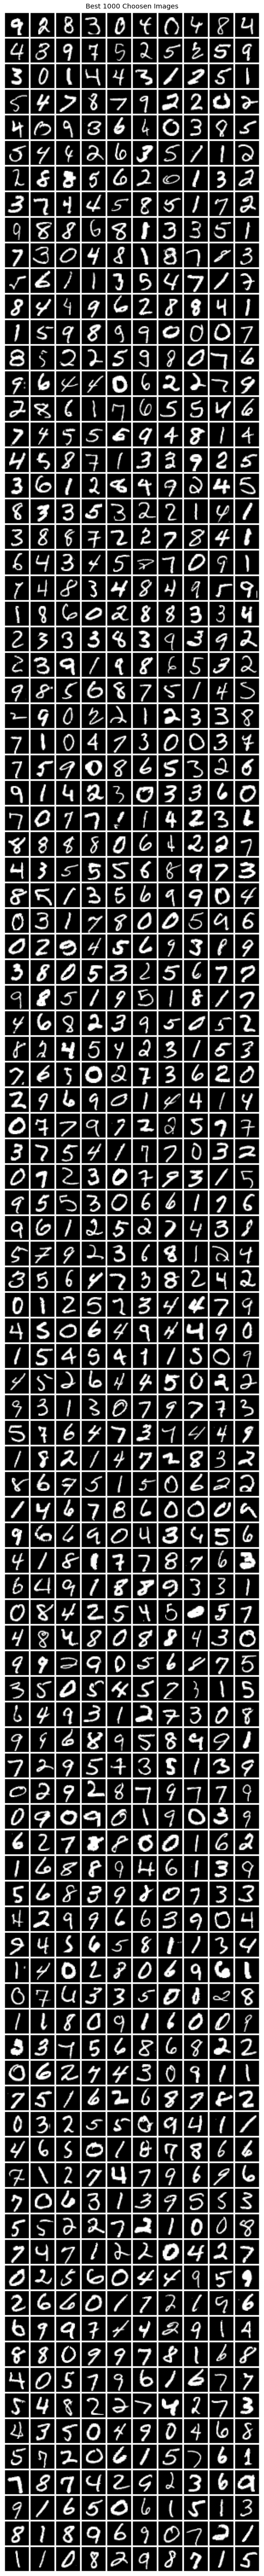

In [ ]:
img_grid = make_grid(images, 10, pad_value=1, normalize=True)
plt.figure(figsize=(10, topn//10))
plt.title(f"Best {topn} Choosen Images")
plt.imshow(img_grid.permute(1,2,0))
plt.axis('off')
plt.show()

In [ ]:
images = images.reshape(len(data), -1).to(Device)
labels = labels.to(Device)
images.shape

torch.Size([1000, 784])

In [ ]:
val_size = int(0.1*labels.shape[0])
sections = (labels.shape[0]-val_size, val_size)
train_images, val_images = torch.split(images, sections)
train_labels, val_labels = torch.split(labels, sections)
print("Train Set: ", train_images.shape, train_labels.shape)
print("Val Set: ", val_images.shape, val_labels.shape)

Train Set:  torch.Size([900, 784]) torch.Size([900])
Val Set:  torch.Size([100, 784]) torch.Size([100])


In [ ]:
test_loader = DataLoader(test_data, batch_size=200, num_workers=2, pin_memory=True)

## Model

In [ ]:
def get_layers():
    layers = []
    for i in range(len(layer_sizes)-1):
        layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        layers.append(nn.ReLU())
    layers.insert(2, nn.Dropout())
    layers.insert(5, nn.Dropout())
    layers[-1] = nn.LogSoftmax(1)
    return layers
layers = get_layers()
model = nn.Sequential(*layers).to(Device)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight)
        nn.init.normal_(m.bias)
        m.weight.data.multiply_(0.1)
        m.bias.data.multiply_(0.1)
model.apply(init_weights)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=128, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=10, bias=True)
  (9): LogSoftmax(dim=1)
)

## Training Utils

In [ ]:
from torch import no_grad

In [ ]:
@no_grad()
def test(loader, model):
    model.eval()
    correct = 0
    for (images, labels) in loader:
        images, labels = images.to(Device).reshape(images.shape[0], -1), labels.to(Device)
        output = model(images)
        acc = output.argmax(dim=1).eq(labels).sum().item()
        correct += acc
    return correct

In [ ]:
@no_grad()
def val(val_i, val_l, model, criterion):
    model.eval()
    output = model(val_i)
    loss = criterion(output, val_l)
    acc = output.argmax(dim=1).eq(val_l).float().mean().item()
    return loss, acc

In [ ]:
lr = 0.05
optimizer = SGD(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.NLLLoss()

In [ ]:
Epochs = 500

In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=10, min_delta=1e-4):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
    def __call__(self, val_acc):
        if  val_acc < 0.6:
            return
        if self.best_acc == None:
            self.best_acc = val_acc
        elif val_acc - self.best_acc > self.min_delta:
            self.best_acc = val_acc
            # reset counter if validation acc improves
            self.counter = 0
        elif val_acc - self.best_acc < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
# ref : https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/

## Training Loop

In [ ]:
early_stopping = EarlyStopping()
losses, accs, val_losses, val_accs = [], [], [], []
for epoch in tqdm(range(Epochs)):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    output = model(train_images)
    loss = criterion(output, train_labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
    accs.append(acc)
    val_loss, val_acc = val(val_images, val_labels, model, criterion)
    val_losses.append(val_loss.item())
    val_accs.append(val_acc)
    early_stopping(val_acc)
    # print(f"Epoch[{epoch+1:4}] Val_Loss: {val_loss:.3f}\tVal_Acc: {val_acc:.3f}")
    if epoch % 50 == 0:
        
        correct = test(test_loader, model)
        print(f"Epoch[{epoch+1:4}] Loss: {loss.item():.2f}\tAccuracy: {acc*100 :.3f}\tVal_Loss: {val_loss:.3f}\tVal_Acc: {val_acc*100:.3f}")
        print(f"Epoch[{epoch+1:4}] Test Accuracy: {(correct / len(test_data))*100 :.3f}")
    if early_stopping.early_stop:
        print(f"Trained for {epoch+1} Epochs.")
        break

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 5.44	Accuracy: 9.556	Val_Loss: 2.439	Val_Acc: 12.000
Epoch[   1] Test Accuracy: 11.490
Epoch[  51] Loss: 1.67	Accuracy: 39.333	Val_Loss: 1.361	Val_Acc: 56.000
Epoch[  51] Test Accuracy: 65.540
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Trained for 73 Epochs.


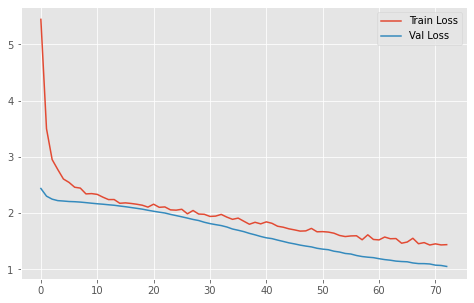

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.savefig(f"LossCurve_greedy{topn}")
plt.show()

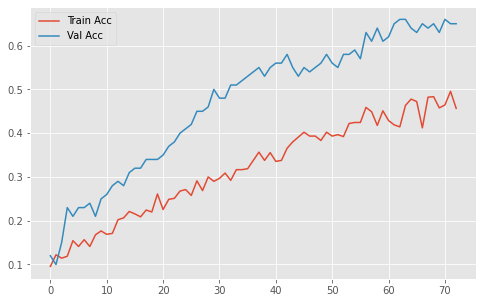

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.savefig(f"AccCurve_greedy{topn}")
plt.show()

In [ ]:
model.eval()
output = model(train_images)
acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
print("Accuracy on Train Set", acc*100)
correct = test(test_loader, model)
print(correct, 'correctly labeled out of', len(test_data))
test_acc = correct / len(test_data) * 100
print('Accuracy on Test Set:', test_acc)

Accuracy on Train Set 73.66666793823242
7276 correctly labeled out of 10000
Accuracy on Test Set: 72.76


In [ ]:
torch.save(model.state_dict(), f"Greedy_Model_{topn}n_Epochs_{Epochs}_Early_Stop_{epoch+1}_Test_Acc_{int(test_acc)}.pth")

<a name="Section3"></a>
# Training on Randomly Sampled Data

In [ ]:
Rand_Train_Acc, Rand_Val_Acc = [], []

## Dataset

In [ ]:
inds = torch.randint(0, 60000, (topn,))
inds.shape

torch.Size([1000])

In [ ]:
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
data = Subset(MNIST("./", transform=transform, download=True), inds)
test_data = MNIST("./", False, transform=transform, download=True)

In [ ]:
images, labels = next(iter(DataLoader(data, len(data), shuffle=True)))
images.shape, labels.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

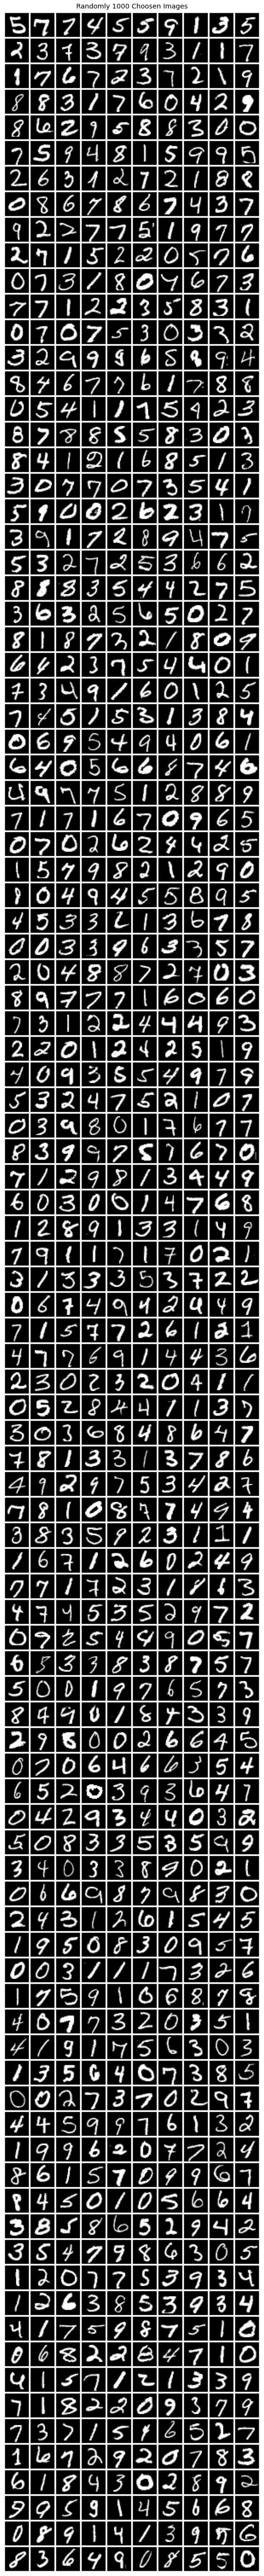

In [ ]:
img_grid = make_grid(images, 10, pad_value=1, normalize=True)
plt.figure(figsize=(10, topn//10))
plt.title(f"Randomly {topn} Choosen Images")
plt.imshow(img_grid.permute(1,2,0))
plt.axis('off')
plt.show()

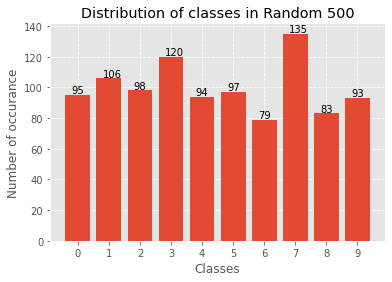

In [ ]:
plt.figure()
unique_and_counts = np.unique(labels, return_counts=True)
plt.bar(*unique_and_counts)
plt.xticks(unique_and_counts[0])
plt.xlabel("Classes")
plt.ylabel('Number of occurance')
plt.title("Distribution of classes in Random 500")
plt.grid(linestyle='--')
for i, v in enumerate(unique_and_counts[1]):
    plt.text(i-0.2, v + 1, str(v))
plt.show()

In [ ]:
images = images.reshape(len(data), -1).to(Device)
labels = labels.to(Device)
images.shape

torch.Size([1000, 784])

In [ ]:
val_size = int(0.1*labels.shape[0])
sections = (labels.shape[0]-val_size, val_size)
train_images, val_images = torch.split(images, sections)
train_labels, val_labels = torch.split(labels, sections)
print("Train Set: ", train_images.shape, train_labels.shape)
print("Val Set: ", val_images.shape, val_labels.shape)

Train Set:  torch.Size([900, 784]) torch.Size([900])
Val Set:  torch.Size([100, 784]) torch.Size([100])


In [ ]:
test_loader = DataLoader(test_data, batch_size=200, num_workers=2, pin_memory=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.43	Accuracy: 10.444	Val_Loss: 2.411	Val_Acc: 11.000
Epoch[   1] Test Accuracy: 11.920
Epoch[  51] Loss: 1.73	Accuracy: 40.778	Val_Loss: 1.560	Val_Acc: 63.000
Epoch[  51] Test Accuracy: 64.270
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early

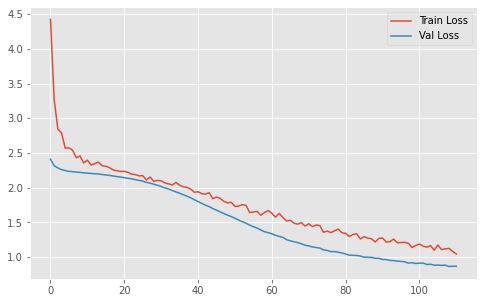

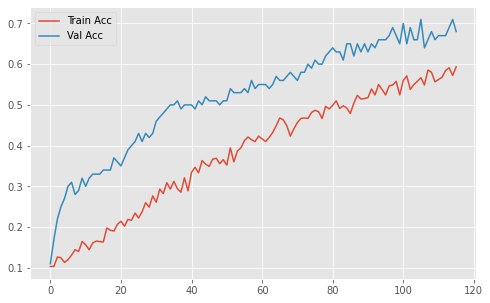

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 5.97	Accuracy: 8.111	Val_Loss: 2.788	Val_Acc: 9.000
Epoch[   1] Test Accuracy: 13.310
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
Epoch[  51] Loss: 1.58	Accuracy: 40.889	Val_Loss: 1.249	Val_Acc: 63.000
Epoch[  51] Test Accuracy: 63.010
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Trained for 52 Epochs.


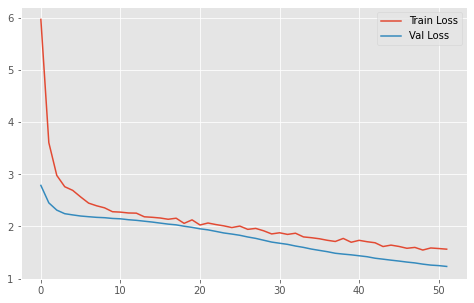

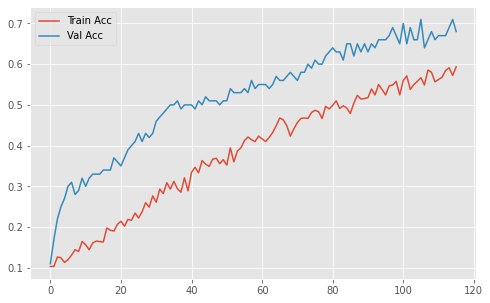

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.54	Accuracy: 11.444	Val_Loss: 2.227	Val_Acc: 17.000
Epoch[   1] Test Accuracy: 12.050
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
Epoch[  51] Loss: 1.51	Accuracy: 49.444	Val_Loss: 1.272	Val_Acc: 67.000
Epoch[  51] Test Accuracy: 66.260
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early

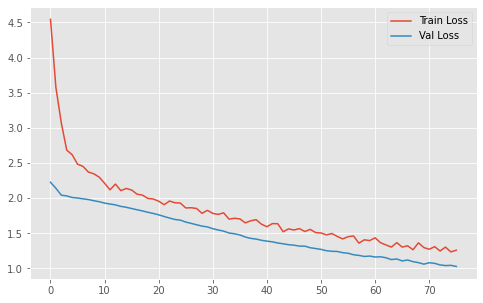

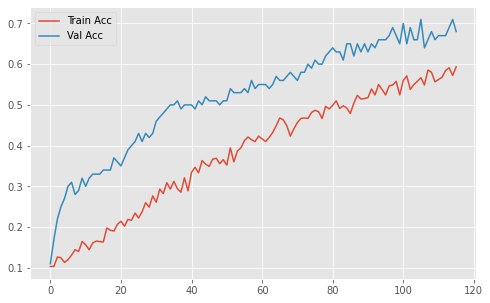

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.56	Accuracy: 11.000	Val_Loss: 2.386	Val_Acc: 18.000
Epoch[   1] Test Accuracy: 15.170
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
Epoch[  51] Loss: 1.58	Accuracy: 42.556	Val_Loss: 1.370	Val_Acc: 63.000
Epoch[  51] Test Accuracy: 69.470
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early

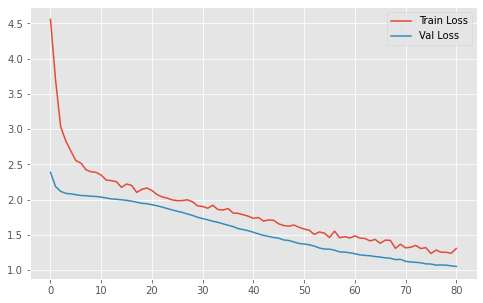

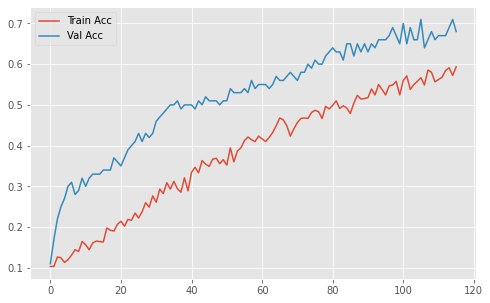

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.59	Accuracy: 8.222	Val_Loss: 2.661	Val_Acc: 9.000
Epoch[   1] Test Accuracy: 10.370
Epoch[  51] Loss: 1.66	Accuracy: 41.444	Val_Loss: 1.291	Val_Acc: 63.000
Epoch[  51] Test Accuracy: 66.400
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early 

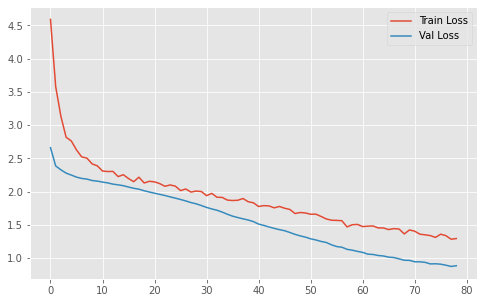

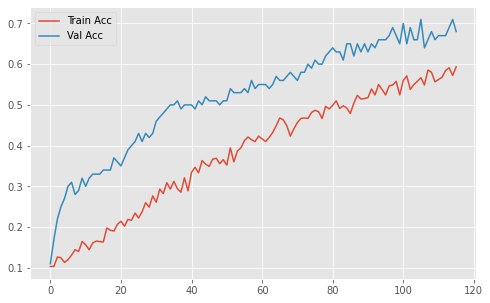

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 6.08	Accuracy: 8.778	Val_Loss: 2.879	Val_Acc: 14.000
Epoch[   1] Test Accuracy: 14.820
Epoch[  51] Loss: 1.62	Accuracy: 43.333	Val_Loss: 1.391	Val_Acc: 55.000
Epoch[  51] Test Accuracy: 58.370
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Trained for 80 Epochs.


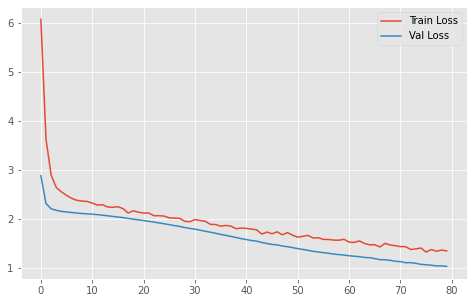

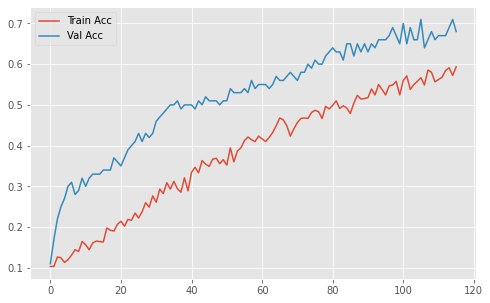

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 3.75	Accuracy: 8.444	Val_Loss: 2.410	Val_Acc: 11.000
Epoch[   1] Test Accuracy: 12.570
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
Epoch[  51] Loss: 1.72	Accuracy: 38.778	Val_Loss: 1.333	Val_Acc: 65.000
Epoch[  51] Test Accuracy: 61.340
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Trained for 58 Epochs.


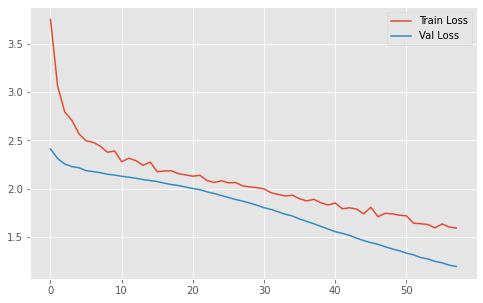

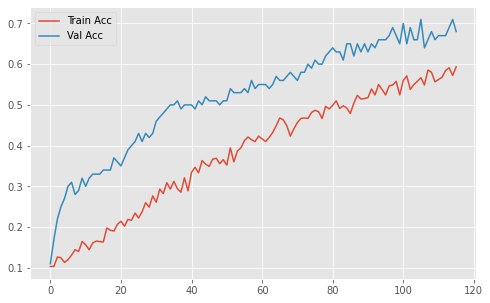

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.50	Accuracy: 10.111	Val_Loss: 2.554	Val_Acc: 6.000
Epoch[   1] Test Accuracy: 7.530
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
Epoch[  51] Loss: 1.70	Accuracy: 42.000	Val_Loss: 1.394	Val_Acc: 62.000
Epoch[  51] Test Accuracy: 59.970
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Trained for 57 Epochs.


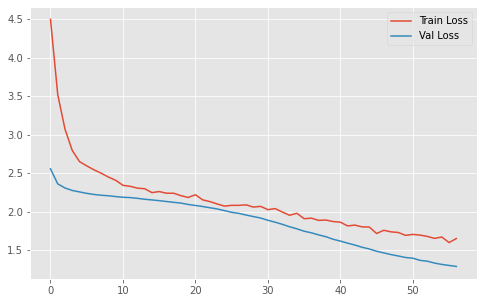

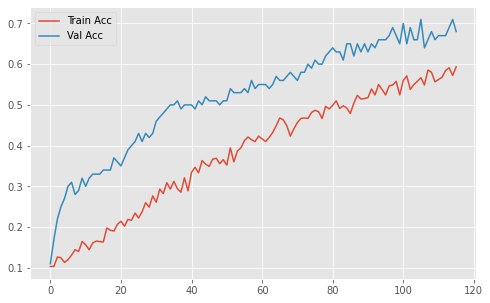

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.20	Accuracy: 8.222	Val_Loss: 2.381	Val_Acc: 12.000
Epoch[   1] Test Accuracy: 10.370
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 1 of 10
Epoch[  51] Loss: 1.56	Accuracy: 44.667	Val_Loss: 1.257	Val_Acc: 64.000
Epoch[  51] Test Accuracy: 64.870
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early 

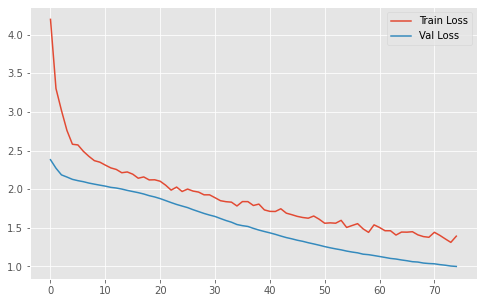

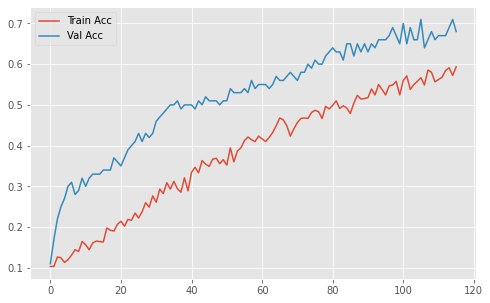

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 5.56	Accuracy: 8.889	Val_Loss: 2.630	Val_Acc: 11.000
Epoch[   1] Test Accuracy: 14.570
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
Epoch[  51] Loss: 1.54	Accuracy: 48.000	Val_Loss: 1.223	Val_Acc: 65.000
Epoch[  51] Test Accuracy: 64.540
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early 

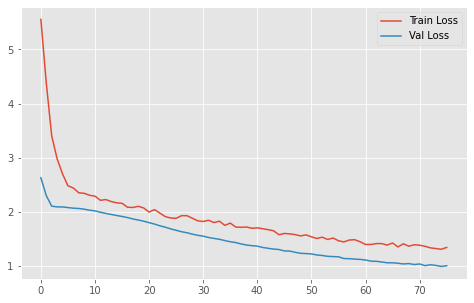

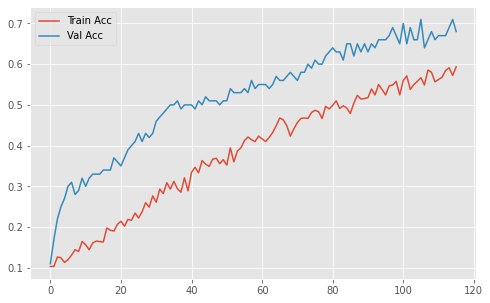

In [ ]:
for i in tqdm(range(10)):

    ### Dataset
    inds = torch.randint(0, 60000, (topn,))
    transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    data = Subset(MNIST("./", transform=transform, download=True), inds)
    test_data = MNIST("./", False, transform=transform, download=True)
    images, labels = next(iter(DataLoader(data, len(data), shuffle=True)))
    images = images.reshape(len(data), -1).to(Device)
    labels = labels.to(Device)

    val_size = int(0.1*labels.shape[0])
    sections = (labels.shape[0]-val_size, val_size)
    train_images, val_images = torch.split(images, sections)
    train_labels, val_labels = torch.split(labels, sections)

    test_loader = DataLoader(test_data, batch_size=200, num_workers=2, pin_memory=True)

    ### Model
    layers = get_layers()
    model = nn.Sequential(*layers).to(Device)
    model.apply(init_weights)

    ### Train Utils
    lr = 0.05
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.NLLLoss()

    Epochs = 500

    ### Train Loop
    early_stopping = EarlyStopping()
    losses2, accs2, val_losses2, val_accs2 = [], [], [], []
    for epoch in tqdm(range(Epochs)):
        model.train()
        optimizer.zero_grad(set_to_none=True)
        output = model(train_images)
        loss = criterion(output, train_labels)
        loss.backward()
        optimizer.step()
        losses2.append(loss.item())
        acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
        accs2.append(acc)
        val_loss, val_acc = val(val_images, val_labels, model, criterion)
        val_losses2.append(val_loss.item())
        val_accs2.append(val_acc)
        early_stopping(val_acc)
        # print(f"Epoch[{epoch+1:4}] Val_Loss: {val_loss:.3f}\tVal_Acc: {val_acc:.3f}")
        if epoch % 50 == 0:
            
            correct = test(test_loader, model)
            print(f"Epoch[{epoch+1:4}] Loss: {loss.item():.2f}\tAccuracy: {acc*100 :.3f}\tVal_Loss: {val_loss:.3f}\tVal_Acc: {val_acc*100:.3f}")
            print(f"Epoch[{epoch+1:4}] Test Accuracy: {(correct / len(test_data))*100 :.3f}")
        if early_stopping.early_stop:
            print(f"Trained for {epoch+1} Epochs.")
            break

    plt.figure(figsize=(8,5))
    plt.plot(losses2, label="Train Loss")
    plt.plot(val_losses2, label="Val Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.show()

    model.eval()
    output = model(train_images)
    acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
    Rand_Train_Acc.append(acc*100)
    correct = test(test_loader, model)
    Rand_Val_Acc.append((correct / len(test_data))*100)

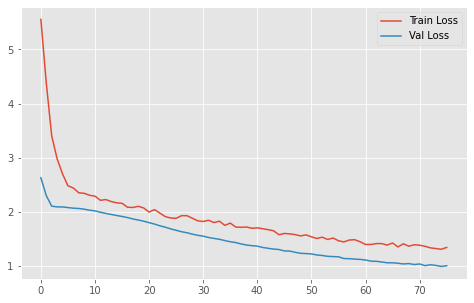

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(losses2, label="Train Loss")
plt.plot(val_losses2, label="Val Loss")
plt.legend()
plt.savefig("LossCurve_random100")
plt.show()

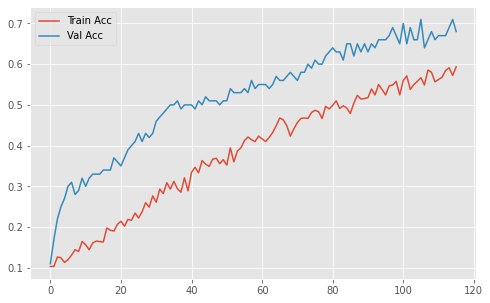

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.savefig("AccCurve_random100")
plt.show()

In [ ]:
model.eval()
correct = test(test_loader, model)
print(correct, 'correctly labeled out of', len(test_data))
print('Accuracy on Test Set:', correct / len(test_data) * 100)

7088 correctly labeled out of 10000
Accuracy on Test Set: 70.88


In [ ]:
print(f"Mean Train Accuracy on Random 100 Train Samples is {np.mean(Rand_Train_Acc):.4f}±{np.std(Rand_Train_Acc):.2f}%")
print(f"Mean Val   Accuracy on Random 100 Train Samples is {np.mean(Rand_Val_Acc):.4f}±{np.std(Rand_Val_Acc):.2f}%")

Mean Train Accuracy on Random 100 Train Samples is 74.3444±5.75%
Mean Val   Accuracy on Random 100 Train Samples is 69.8920±4.79%
